## Load packages and data


In [ ]:
# General utilities
import os
import numpy as np
import pandas as pd
import pickle
import random
import time

# Image processing
from PIL import Image
import cv2

# Machine learning and neural network Pytorch
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Setting the seed for Python's built-in random module
random.seed(42)

# Setting the seed for NumPy's random number generation
np.random.seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/COMP642-project/PlantVillage" -d "/content/dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/f2cfc53d-a165-47d5-a9ac-6877e52a97b6___GCREC_Bact.Sp 3804.JPG  
  inflating: /content/dataset/__MACOSX/PlantVillage/Tomato_Bacterial_spot/._f2cfc53d-a165-47d5-a9ac-6877e52a97b6___GCREC_Bact.Sp 3804.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/4c24021e-90e2-4b84-89c2-c904dc8bb0b4___GCREC_Bact.Sp 5706.JPG  
  inflating: /content/dataset/__MACOSX/PlantVillage/Tomato_Bacterial_spot/._4c24021e-90e2-4b84-89c2-c904dc8bb0b4___GCREC_Bact.Sp 5706.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/9be85690-9fdb-4ddd-b007-686bc4074786___GCREC_Bact.Sp 5780.JPG  
  inflating: /content/dataset/__MACOSX/PlantVillage/Tomato_Bacterial_spot/._9be85690-9fdb-4ddd-b007-686bc4074786___GCREC_Bact.Sp 5780.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/0b233197-cd35-4031-80c2-610e7e3a046b___GCREC_Bact.Sp 6095.JPG  
  inflating: 

## Helper function

In [ ]:
# make a new directory
def mkdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        print('> Creating: {}'.format(path))

# check for cuda and select gpu for training or otherwise cpu
def getDevice():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}, {torch.cuda.get_device_name(device)}')
    return device

# resample a target class if the dataset is heavily imbalanced
def rebalanceDataset(img_df, label_df, num_sample=10000):
    train_df = pd.concat([img_df, label_df], axis=1)
    train_df.columns = ['img', 'label']

    target_df = train_df[train_df['label'] == 0]
    resample_df = resample(target_df, replace=False, n_samples=num_sample)

    new_train_df = pd.concat([resample_df, train_df[train_df['label'] != 0]])

    return new_train_df['img'], new_train_df['label']

# evaluate the model by returning the predictions and target label
def evaluate(model, data_loader, device):
    predict = []
    target = []
    with torch.no_grad():
        model.eval()
        for idx, (x, label) in enumerate(data_loader):
            x, label = x.to(device), label.to(device)
            output = model(x)

            predict.extend(torch.argmax(output.data, 1).detach().cpu())
            target.extend(label.detach().cpu())
    return target, predict


def countplot(dataframe):
    ax = sns.countplot(x=dataframe)
    for num in ax.containers:
        ax.bar_label(num)
    plt.savefig('./figures/countplot.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, normalize='true', title=None, cmap=plt.cm.Blues):
    matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=normalize)
    ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=np.arange(classes)).plot(cmap=cmap)
    plt.title('Normalized confusion matrix ({})'.format(title))
    plt.savefig('./figures/confusion_matrix_' + title + '.png')
    # plt.show()


def plot_grpah(train_acc, val_acc, train_loss, val_loss, model):
    epochs = range(1, len(train_acc) + 1)

    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Testing accuracy')
    plt.title(f'{model} Training and Testing Accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Testing loss')
    plt.title(f'{model} Training and Testing Loss')
    plt.legend()
    plt.show()


def get_report(y_true, y_pred):
    # Convert tensor lists to numpy arrays if they're not already
    y_true_np = [y.item() for y in y_true]  # Assuming y_true is a list of tensors
    y_pred_np = [y.item() for y in y_pred]  # Assuming y_pred is a list of tensors

    # Generate the classification report
    clr = classification_report(y_true_np, y_pred_np, target_names=dataset.classes, digits=3, output_dict=True)
    print(classification_report(y_true_np, y_pred_np, target_names=dataset.classes))

    # Overall accuracy
    overall_accuracy =  accuracy_score(y_true_np, y_pred_np)

    # Extract overall precision, recall, f1-score from the classification report
    overall_precision = clr['weighted avg']['precision']
    overall_recall = clr['weighted avg']['recall']
    overall_f1 = clr['weighted avg']['f1-score']

    print(f'Overall Accuracy: {overall_accuracy:.3f}')
    print(f'Overall Precision: {overall_precision:.3f}')
    print(f'Overall Recall: {overall_recall:.3f}')
    print(f'Overall F1-Score: {overall_f1:.3f}')

    conf_matrix = confusion_matrix(y_true_np, y_pred_np)
    print(conf_matrix)

    # Calculate accuracy per class
    class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

    # Print accuracy per class
    print("Class Accuracy:")
    for idx, class_accuracy in enumerate(class_accuracies):
        print(f"{dataset.classes[idx]}: {class_accuracy:.3f}")

## Data Pre-processing

In [ ]:
# Define parameters (typically passed as arguments in a script)
num_epochs = 10
lr = 0.003
batch_size = 64
model_name = "resnet18"
tl_mode = "finetune"  # Options: 'no_pretrain', 'linear_probe', 'finetune'

In [ ]:
# Create necessary directories
mkdir('figures')
mkdir('checkpoint')

# Use GPU if available
device = getDevice()

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjusting the size to match ResNet18 requirements
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

> Creating: figures
> Creating: checkpoint
Using device: cuda:0, Tesla T4


In [ ]:
# Load dataset
dataset = ImageFolder(root='/content/dataset/PlantVillage', transform=transform)
print(f"Dataset total size: {len(dataset)}.")
print(f"Classes: {dataset.classes}.")

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)



Dataset total size: 16011.
Classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy'].


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Initialize the model
if tl_mode != "no_pretrain":
    model = resnet18(pretrained=True)
    # Freeze model parameters if in linear_probe mode
    if tl_mode == "linear_probe":
        for param in model.parameters():
            param.requires_grad = False
else:
    model = resnet18(pretrained=False)

# Replace the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [ ]:
# Initialize placeholders for tracking training and testing metrics
train_total_loss, train_total_acc, test_total_loss, test_total_acc = [], [], [], []

best_acc = 0.0
state = {'model': None, 'acc': 0, 'epoch': 0}

start_time = time.time()
# Training and Testing Loops
for epoch in range(num_epochs):
    model.train()
    train_total, train_loss, train_correct = 0, 0, 0
    for idx, (x, label) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        x, label = x.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(output, dim=1)
        train_total += label.size(0)
        train_correct += (predicted == label).sum().item()
        train_loss += loss.item()

    train_loss_avg = train_loss / len(train_loader)
    train_acc_avg = train_correct / train_total
    train_total_loss.append(train_loss_avg)
    train_total_acc.append(train_acc_avg)

    # Testing loop
    test_total, test_loss, test_correct = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = loss_fn(outputs, target)

            predicted = torch.argmax(outputs, dim=1)
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
            test_loss += loss.item()

    test_loss_avg = test_loss / len(test_loader)
    test_acc_avg = test_correct / test_total
    test_total_loss.append(test_loss_avg)
    test_total_acc.append(test_acc_avg)

    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'[Train] loss: {train_loss_avg:.5f}, acc: {train_acc_avg:.2f}%')
    print(f'[Test]  loss: {test_loss_avg:.5f}, acc: {test_acc_avg:.2f}%')

    # Save checkpoint if improved
    if test_acc_avg > best_acc:
        best_acc = test_acc_avg
        state = {'model': model.state_dict(), 'acc': best_acc, 'epoch': epoch}
        print('- New checkpoint -')

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time//60:.0f}m {total_time%60:.0f}s')
    # Here, you'd save the state dict as shown, adjusted for Jupyter Notebook context
    # torch.save(state, f'./checkpoint/{model_name}_{tl_mode}_epoch_{epoch+1}.pth')

Epoch 1/10:   0%|          | 0/201 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1/10
[Train] loss: 0.36919, acc: 0.89%
[Test]  loss: 0.09544, acc: 0.97%
- New checkpoint -


Epoch 2/10:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 2/10
[Train] loss: 0.04199, acc: 0.99%
[Test]  loss: 0.05012, acc: 0.99%
- New checkpoint -


Epoch 3/10:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 3/10
[Train] loss: 0.01717, acc: 1.00%
[Test]  loss: 0.03706, acc: 0.99%
- New checkpoint -


Epoch 4/10:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 4/10
[Train] loss: 0.00867, acc: 1.00%
[Test]  loss: 0.03502, acc: 0.99%
- New checkpoint -


Epoch 5/10:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 5/10
[Train] loss: 0.00849, acc: 1.00%
[Test]  loss: 0.04135, acc: 0.99%


Epoch 6/10:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 6/10
[Train] loss: 0.01538, acc: 1.00%
[Test]  loss: 0.02902, acc: 0.99%
- New checkpoint -


Epoch 7/10:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 7/10
[Train] loss: 0.01083, acc: 1.00%
[Test]  loss: 0.02646, acc: 0.99%
- New checkpoint -


Epoch 8/10:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 8/10
[Train] loss: 0.00438, acc: 1.00%
[Test]  loss: 0.02852, acc: 0.99%


Epoch 9/10:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 9/10
[Train] loss: 0.00262, acc: 1.00%
[Test]  loss: 0.02546, acc: 0.99%
- New checkpoint -


Epoch 10/10:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch: 10/10
[Train] loss: 0.00294, acc: 1.00%
[Test]  loss: 0.02379, acc: 0.99%
Total training time: 10m 7s


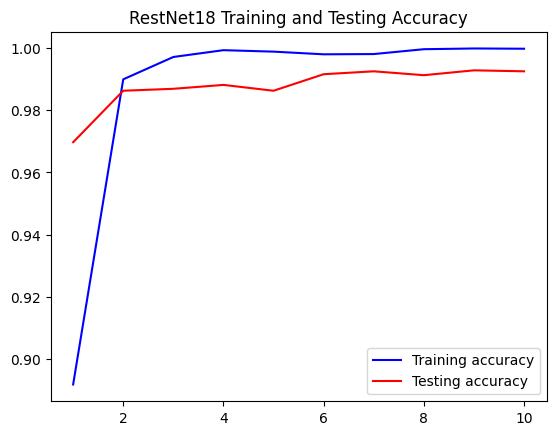

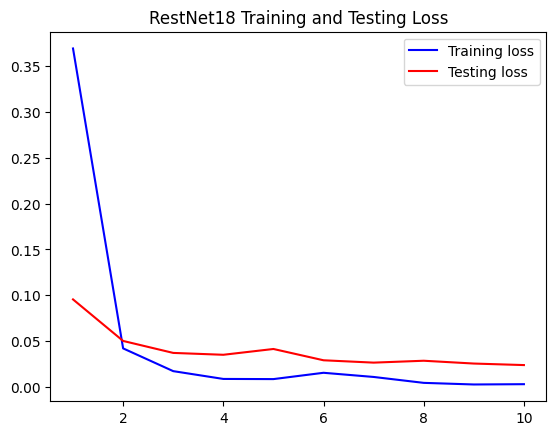

                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       1.00      1.00      1.00       449
                        Tomato_Early_blight       0.98      0.96      0.97       195
                         Tomato_Late_blight       0.99      0.99      0.99       380
                           Tomato_Leaf_Mold       1.00      0.99      0.99       185
                  Tomato_Septoria_leaf_spot       1.00      1.00      1.00       345
Tomato_Spider_mites_Two_spotted_spider_mite       0.99      0.98      0.99       315
                        Tomato__Target_Spot       0.97      0.99      0.98       294
      Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      1.00      1.00       660
                Tomato__Tomato_mosaic_virus       1.00      1.00      1.00        77
                             Tomato_healthy       1.00      1.00      1.00       303

                                   accuracy                    

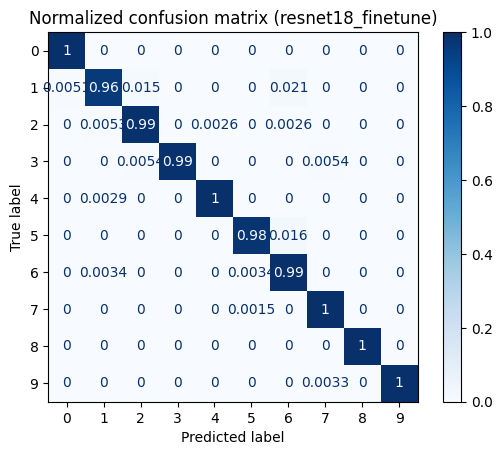

In [ ]:
model.load_state_dict(state['model'])
y_true, y_pred = evaluate(model, test_loader, device)
plot_grpah(train_total_acc, test_total_acc, train_total_loss, test_total_loss, 'RestNet18')
get_report(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, len(dataset.classes), 'true', f'{model_name}_{tl_mode}')